In [22]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
#obs6=np.array([-4,-4,1])/1.
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-6,-6,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

sensor_noise_sigma = np.zeros(10)
real_disturbance=np.random.normal(loc=0,scale=0.03,size=3)
real_disturbance = np.zeros(3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])
#obs_eigen_values= np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.7, -0.7,-0.7])
def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    traj = []
    N = 10
    for xy_cost in np.array([1,5,10]):

        N = 10

        quadrotor_linear = Quadrotor_linear()
        
        # Some initialisation
        
        x_init = np.zeros(10)
        x_init[0]=drone[0]
        x_init[1]=drone[1]
        
        x_target = np.zeros(10)
        x_target[0] = goal[0]
        x_target[1] = goal[1]
        x_target[2] = goal[2]
        
        x_hat = x_init
        x_real = x_init
        d_hat=np.zeros((3,1))
        output = x_init
        
        L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
        
        # Get convex workspace with constraints for obstacles
        A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
        #Get intermediate goal in this convex space
        inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
        x_intergoal=np.zeros(10)
        x_intergoal[:2]=inter_goal
        x_intergoal[2] = x_target[2]

        real_trajectory = {'x': [], 'y': [], 'z': []}
        est_trajectory = {'x': [], 'y': [], 'z': []}
        output_trajectory = {'x': [], 'y': [], 'z': []}
        
        d_hat_list=[]
        
        # Optimal target selector
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

        i = 0
        while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1 and i<500: #until intergoal and final goal are equal
            
            i += 1 #limit number of iterations

            # Get obstacle matrix
            A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
            
            #Compute the input with mpc
            u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs, xy_cost=xy_cost)

            if u is None:
                # if failure from MPC, u=0, which means hover input
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            # Plant
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            #Observer
            x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
            
            d_hat_list.append(d_hat)
            
            #Recompute obstacles and intermediate goal
            A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
            
            x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

            if x_ref is None : #if failure from target selector
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
            
            print(i)
            print("x_real :",x_real)
            
        #intermediate goal = final goal, so we pass on stable MPC with time invariant constraints  
        A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
        print("***")

        while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.3 and i<=1000: #until reach final goal
            i+=1
            
            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
            
            # Use the mpc with terminal cost and set
            u = mpc_control_stable(quadrotor_linear, 3*N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A,b, xy_cost=xy_cost)


            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            #Plant
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            #Observer
            x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
            d_hat_list.append(d_hat)
            #Optimal target selector
            x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)

            print(i)
            print("x_real :",x_real)
            
            if x_ref is None :#if failure from target selector
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
            
        traj.append(real_trajectory)
    

real _dist [0. 0. 0.]
1
x_real : [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.92243994]
 [ 0.        ]
 [ 0.        ]
 [ 0.34849963]
 [-0.70275087]]
2
x_real : [[ 0.        ]
 [ 0.        ]
 [ 0.09224399]
 [ 0.        ]
 [ 0.        ]
 [ 1.19104557]
 [ 0.03484996]
 [-0.07027509]
 [ 0.19923604]
 [-0.37441569]]
3
x_real : [[ 0.        ]
 [ 0.        ]
 [ 0.21134855]
 [-0.06893986]
 [-0.03418781]
 [ 1.18870324]
 [ 0.05477357]
 [-0.10771666]
 [ 0.0474288 ]
 [-0.13885268]]
4
x_real : [[-0.00689399]
 [-0.00341878]
 [ 0.33021887]
 [-0.1746099 ]
 [-0.08792068]
 [ 1.12666277]
 [ 0.05951645]
 [-0.12160192]
 [-0.01202754]
 [ 0.03228895]]
5
x_real : [[-0.02435498]
 [-0.01221085]
 [ 0.44288515]
 [-0.29390139]
 [-0.14630632]
 [ 1.05465328]
 [ 0.05831369]
 [-0.11837303]
 [-0.05172954]
 [ 0.12668067]]
6
x_real : [[-0.05374511]
 [-0.02684148]
 [ 0.54835048]
 [-0.41002533]
 [-0.20351205]
 [ 0.98416982]
 [ 0.05314074]
 [-0.10570496]
 [-0.11206236]
 [ 0.18115499]]
7
x_re

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

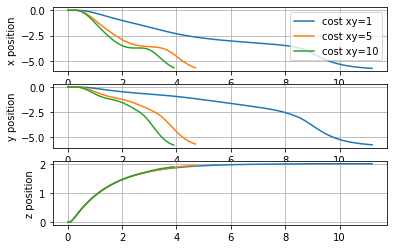

<Figure size 432x288 with 0 Axes>

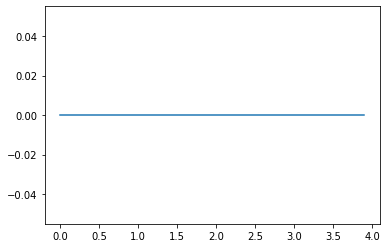

In [21]:
fig, axs = plt.subplots(3)
for real_traj in traj:
    real_traj['x'] = np.array(real_traj['x'], dtype=float)
    real_traj['y'] = np.array(real_traj['y'], dtype=float)
    real_traj['z'] = np.array(real_traj['z'], dtype=float)
    time_range = np.arange(0, real_traj['x'].shape[0]*0.1-0.01, 0.1)
    axs[0].plot(time_range, real_traj['x'])
    axs[0].set_ylabel('x position')
    axs[0].grid()

for real_traj in traj:
    real_traj['x'] = np.array(real_traj['x'], dtype=float)
    real_traj['y'] = np.array(real_traj['y'], dtype=float)
    real_traj['z'] = np.array(real_traj['z'], dtype=float)
    time_range = np.arange(0, real_traj['y'].shape[0]*0.1-0.01, 0.1)
    axs[1].plot(time_range, real_traj['y'])
    axs[1].set_ylabel('y position')
    axs[1].grid()

plt.figure(2)
for real_traj in traj:
    real_traj['x'] = np.array(real_traj['x'], dtype=float)
    real_traj['y'] = np.array(real_traj['y'], dtype=float)
    real_traj['z'] = np.array(real_traj['z'], dtype=float)
    time_range = np.arange(0, real_traj['z'].shape[0]*0.1-0.01, 0.1)
    axs[2].plot(time_range, real_traj['z'])
    axs[2].set_ylabel('z position')
    axs[2].grid()
axs[0].legend(['cost xy=1','cost xy=5','cost xy=10'])

fig.savefig('cost.pdf')
plt.show()





# plt.figure(3)
#plt.plot(np.square((np.array(real_trajectory['x'])-np.array(est_trajectory['x'])).reshape(-1,1)))#,axis=1))

# plt.plot(np.array(real_trajectory['z']).reshape(-1,1))#,axis=1))
# plt.plot(np.array(est_trajectory['z']).reshape(-1,1))
d_hat_list = np.array(d_hat_list).reshape(-1,3)
time_range = np.arange(0, d_hat_list.shape[0]*0.1-0.01, 0.1)
plt.plot(time_range, d_hat_list[:,0])